In [44]:
from tree_sitter import Language, Parser

Language.build_library(
    './build/my-ebnf1.so',  
    ['./tree-sitter-ebnf'] 
)
MY_LANGUAGE = Language('./build/my-ebnf1.so', 'EBNF')

parser = Parser()
parser.set_language(MY_LANGUAGE)
source_code = b"""
externals ::= { line_comment block_comment /\\s/ };
"""

tree = parser.parse(source_code)

root_node = tree.root_node

print(root_node.sexp())


(source_file (ERROR (lhs (identifier)) (ERROR (UNEXPECTED '{')) (statements (identifier)) (statementsNoSelection (identifier)) (ERROR (UNEXPECTED '/')) (quantifierBase (identifier)) (UNEXPECTED '/')))


# Create RRD

In [24]:
from RRD.railroad import Diagram, Choice, Sequence, OptionalSequence, HorizontalChoice, OneOrMore, ZeroOrMore, Optional
from IPython.display import SVG, display
import io

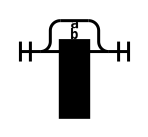

In [13]:
d = Diagram(OptionalSequence('a','b', 'c'))
d = Diagram(Choice(1,'a','b', 'c'))
d = Diagram(ZeroOrMore('a'))
d = Diagram(Optional('a\nb\nc\ng\ns\ns'))

outputStream = io.StringIO()
d.writeStandalone(outputStream.write)
display(SVG(data=outputStream.getvalue()))

In [25]:

def visit(node, diagrams = {}):
    match(node.type):
        case 'source_file':
            for i in range(len(node.children)):
                diagrams =  visit(node.children[i], diagrams)
            return diagrams
        case 'rule':
            name = node.children[0].text.decode()
            diagrams[name] = Diagram(visit(node.children[2]))
            return diagrams
        case 'rhs':
            return visit(node.children[0])
        case 'sequence':
            blocks = []
            for child in node.children:
                blocks.append(visit(child))
            return Sequence(*blocks)
        case 'statements':
            return visit(node.children[0])
        case 'parenthesizedStatement':
            return visit(node.children[1])
        case 'quantifiedStatement':
            return visit(node.children[0])
        case 'selectionStatement':
            blocks = []
            for child in node.children:
                if child.type == 'sequenceNoSelection':
                    blocks.append(visit(child))
            return Choice(len(blocks)//2, *blocks)
        case 'sequenceNoSelection':
            blocks = []
            for child in node.children:
                blocks.append(visit(child))
            return Sequence(*blocks)
        case 'statementsNoSelection':
            return visit(node.children[0])
        case 'optional':
            return Optional(visit(node.children[0]))
        case 'oneOrMore':
            return OneOrMore(visit(node.children[0]))
        case 'zeroOrMore':
            return ZeroOrMore(visit(node.children[0]))
        case 'quantifierBase':
            return visit(node.children[0])
        case 'identifier':
            return node.text.decode() #+ "\nCount: 0\nMetric: 0"
        case _:
            if len(node.children) > 0:
                print('Not implemented: ' + str(node.type))
                for i in range(len(node.children)):
                    return visit(node.children[i])

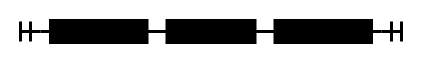

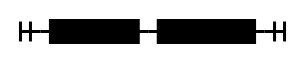

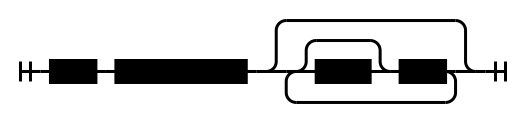

In [33]:
# Parse some code
source_code = b"""
binary_statement ::= statement operator statement;
unary_statement ::= operator statement;
function_definition ::= def function_name ( (type? arg)*? );
"""
node = parser.parse(source_code).root_node
diagrams = visit(node)
d = diagrams['binary_statement']
outputStream = io.StringIO()
d.writeStandalone(outputStream.write)
display(SVG(data=outputStream.getvalue()))
d = diagrams['unary_statement']
outputStream = io.StringIO()
d.writeStandalone(outputStream.write)
display(SVG(data=outputStream.getvalue()))
d = diagrams['function_definition']
outputStream = io.StringIO()
d.writeStandalone(outputStream.write)
display(SVG(data=outputStream.getvalue()))

In [36]:
#!/usr/bin/env python
from RRD.railroad import Diagram, Choice, Sequence, OptionalSequence, HorizontalChoice, OneOrMore, ZeroOrMore, Optional
from IPython.display import SVG, display
import io
from tree_sitter import Language, Parser

Language.build_library(
    './build/my-ebnf.so', 
    ['./tree-sitter-ebnf']     
)
MY_LANGUAGE = Language('./build/my-ebnf.so', 'EBNF')  
parser = Parser()
parser.set_language(MY_LANGUAGE)


def visit(node):

    if node.type == 'source_file':
        rules = {}
        for child in node.children:
            if child.type == 'rule':
                
                rule_name = child.children[0].text.decode()
                
                rule_diagram = visit(child.children[2])
                rules[rule_name] = Diagram(rule_diagram)
        return rules
    elif node.type == 'rule':
        
        rule_name = node.children[0].text.decode()
        return rule_name, visit(node.children[2])
    elif node.type == 'rhs':
        
        if len(node.children) == 1:
            return visit(node.children[0])
        else:
            return Sequence(*[visit(child) for child in node.children])
    elif node.type == 'sequence':
        return Sequence(*[visit(child) for child in node.children])
    elif node.type == 'choice':
        
        return Choice(0, *[visit(child) for child in node.children])
    elif node.type == 'optional':
        return Optional(visit(node.children[0]))
    elif node.type in ('oneOrMore', 'plus'):
        return OneOrMore(visit(node.children[0]))
    elif node.type in ('zeroOrMore', 'star'):
        return ZeroOrMore(visit(node.children[0]))
    elif node.type == 'parenthesized':
        
        return visit(node.children[1])
    elif node.type == 'identifier':
        return node.text.decode()
    elif node.type == 'terminal':
        return node.text.decode()
    else:
        
        if len(node.children) > 0:
            return Sequence(*[visit(child) for child in node.children])
        else:
            return node.text.decode()

#example word ::= identifier;
source_code = b"program ::= toplevel_statement*;"

tree = parser.parse(source_code)
root_node = tree.root_node

diagrams = visit(root_node)

if 'word' in diagrams:
    d = diagrams['word']
    outputStream = io.StringIO()
    d.writeStandalone(outputStream.write)
    display(SVG(data=outputStream.getvalue()))
else:
    print("Not Found")


Not Found


Rule: program


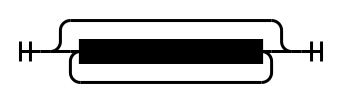

In [ ]:

from RRD.railroad import Diagram, Choice, Sequence, OptionalSequence, HorizontalChoice, OneOrMore, ZeroOrMore, Optional
from IPython.display import SVG, display
import io
from tree_sitter import Language, Parser

Language.build_library(
    './build/my-ebnf.so', 
    ['./tree-sitter-ebnf']     
)
MY_LANGUAGE = Language('./build/my-ebnf.so', 'EBNF')  
parser = Parser()
parser.set_language(MY_LANGUAGE)

def visit(node):

    if node.type in ('source_file', 'grammar'):
        rules = {}
        for child in node.children:
            if child.type == 'rule':
                
                rule_name = child.children[0].text.decode()
                
                rule_diagram = visit(child.children[2])
                rules[rule_name] = Diagram(rule_diagram)
        return rules

    elif node.type == 'rule':
        rule_name = node.children[0].text.decode()
        return rule_name, visit(node.children[2])
   
    elif node.type == 'rhs':
        if len(node.children) == 1:
            return visit(node.children[0])
        else:
            return Sequence(*[visit(child) for child in node.children])
    
    elif node.type == 'sequence':
        return Sequence(*[visit(child) for child in node.children])
    
    elif node.type == 'choice':
        return Choice(0, *[visit(child) for child in node.children])
    
    elif node.type == 'optional':
        return Optional(visit(node.children[0]))
    
    elif node.type in ('oneOrMore', 'plus'):
        return OneOrMore(visit(node.children[0]))
    
    elif node.type in ('zeroOrMore', 'star'):
        return ZeroOrMore(visit(node.children[0]))
    
    elif node.type == 'parenthesized':
        
        return visit(node.children[1])
    
    elif node.type in ('identifier', 'terminal'):
        return node.text.decode()
    
    else:
        if len(node.children) > 0:
            return Sequence(*[visit(child) for child in node.children])
        else:
            return node.text.decode()

source_code = b"""
program ::= _toplevel_statement*;
"""

tree = parser.parse(source_code)
root_node = tree.root_node

diagrams = visit(root_node)

if diagrams:
    for rule_name, diagram in diagrams.items():
        outputStream = io.StringIO()
        diagram.writeStandalone(outputStream.write)
        print("Rule:", rule_name)
        display(SVG(data=outputStream.getvalue()))
else:
    print("No Matching Rule")
